In [2]:
import pandas as pd
import numpy as np

In [3]:
#set up path for data directory 
data_dir = 'data/data/brain_age/'

In [4]:
#metadata containing information for each subject
meta_df=pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_df

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE
...,...,...,...,...
647,CC722542,79,1,MALE
648,CC722651,79,2,FEMALE
649,CC722891,84,2,FEMALE
650,CC723197,80,2,FEMALE


In [55]:
print("Mean Age", np.mean(meta_df['age']))
print("Std Dev" , np.std(meta_df['age']))

Mean Age 54.29907975460123
Std Dev 18.57857956855286


In [5]:
#function to split 3D images into 2D axes and visualize
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display
def display_axes(image):
    plt.figure(figsize = (10,3))
    
    #get an array from 3D image
    image = sitk.GetArrayFromImage(image)
    
    # get centre voxel
    s=np.array(image.shape)
    s=np.around(s/2).astype(int)
    #coro
    plt.subplot(131)
    plt.imshow(image[s[0],:,:], cmap='gray')
    plt.title('axial')
    plt.axis('equal')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(image[::-1,s[1],:], cmap='gray')
    plt.title('coronal')
    plt.axis('equal')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(image[::-1,:,s[2]], cmap='gray')
    plt.title('sagittal')
    plt.axis('equal')
    plt.axis('off')

Brain MRI for CC620785 of age 69
Brain MRI for CC220394 of age 33
Brain MRI for CC410032 of age 55


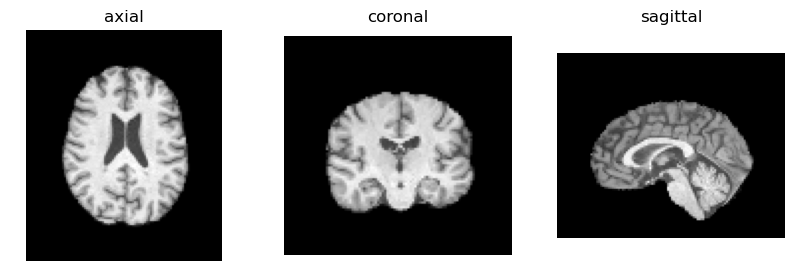

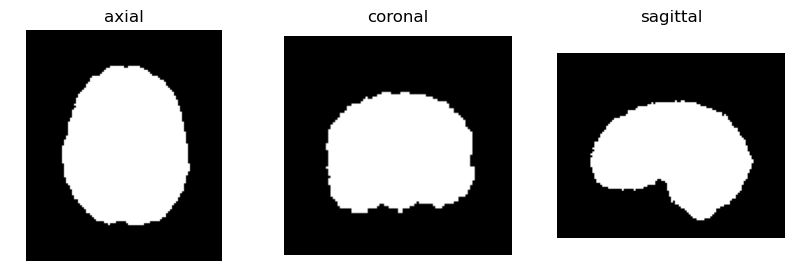

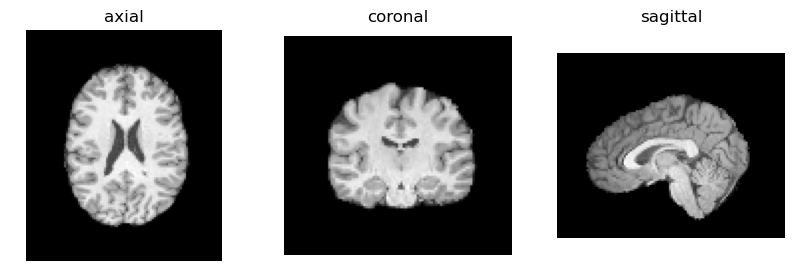

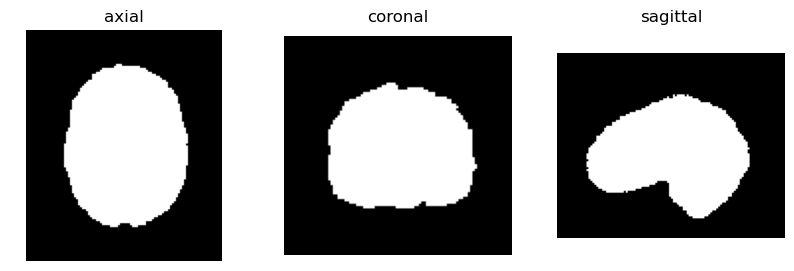

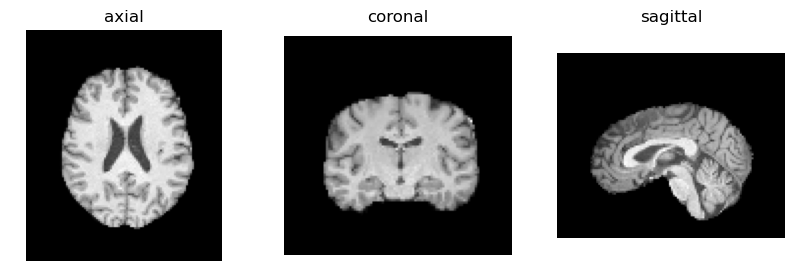

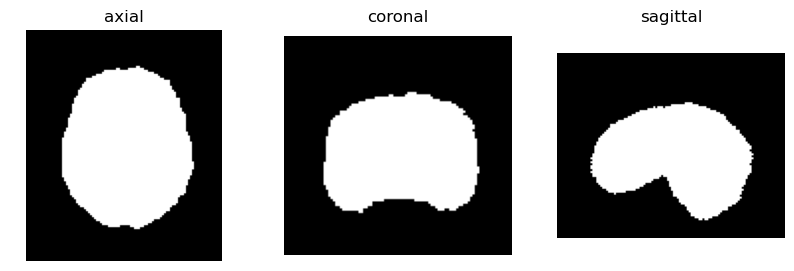

In [18]:
#visualize brain scans in 2D for 5 randomly selected subjects
import random
for i in range (3):

    random_number = random.randint(0,652)
    subject_id = meta_df['subject_id'][random_number]
    age=meta_df['age'][random_number]

# Load Image from directory
    image_filename = data_dir + 'images/sub-' + subject_id + '_T1w_unbiased.nii.gz'
    img = sitk.ReadImage(image_filename)
    mask_filename=data_dir + 'masks/sub-' + subject_id + '_T1w_brain_mask.nii.gz'
    mask=sitk.ReadImage(mask_filename)
    print(f"Brain MRI for {subject_id} of age {age}") 
    display_axes(img)
    display_axes(mask)

**Image Registry**

Often brain scans are different for different people based on their brain structure . It is important to regitser these based on one template so that all MRI scans are comparable.

In [12]:
def registration(fixed_image, moving_image):

    # Create an instance of ImageRegistrationMethod
    registration = sitk.ImageRegistrationMethod()

    # Set the metric as correlation and specify optimizer parameters
    registration.SetMetricAsCorrelation()
    registration.SetOptimizerAsRegularStepGradientDescent(learningRate=5.0,
                                           minStep=1e-4,
                                           numberOfIterations=20,
                                           gradientMagnitudeTolerance=1e-8)

    # Set optimizer scales based on index shift
    registration.SetOptimizerScalesFromIndexShift()

    # Calculate an initial transformation for geometric alignment
    initialization = sitk.CenteredTransformInitializer(fixed_image, 
                                              moving_image, 
                                              sitk.AffineTransform(3), 
                                              sitk.CenteredTransformInitializerFilter.GEOMETRY)

    # Set the initial transform and interpolator
    registration.SetInitialTransform(initialization)
    registration.SetInterpolator(sitk.sitkLinear)

    # Execute the registration process
    output= registration.Execute(fixed_image, moving_image)
    
    return output  # Return the transformation

def resample_image(reference, floating,transformation):
    res = sitk.ResampleImageFilter()
    res.SetReferenceImage(reference)
    res.SetInterpolator(sitk.sitkLinear)
    res.SetDefaultPixelValue(0)

    res.SetTransform(transformation)
    return res.Execute(floating)

In [43]:
#Choose an image as fixed image
import os
output_directory=data_dir+'/registered_1'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
all_subject_ids=meta_df['subject_id']
image_filenames=[data_dir + 'MRI_all/sub-' + f + '_T1w_unbiased.nii.gz' for f in all_subject_ids]
fixed_image=image_filenames[0]
fixed_image=sitk.ReadImage(fixed_image)
for idx,filename in enumerate(image_filenames[1:]):
    moving_image=sitk.ReadImage(filename)
    transf = registration(moving_image,fixed_image)
    registered_image=resample_image(img, sitk_atlas, transformation = transf)
    sitk.WriteImage(registered_image, os.path.join(output_directory, f"registered_{idx}.nii.gz"))


In [34]:
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [35]:
#data preprocesing pipeline

class ImagePreprocessor:
    def normalize(image, mask):
        #normalizes image using mask
        img_array = sitk.GetArrayFromImage(image).astype(np.float32)
        msk_array = sitk.GetArrayFromImage(mask)

        mean = np.mean(img_array[msk_array > 0])
        std = np.std(img_array[msk_array > 0])

        if std > 0:
            img_array = (img_array - mean) / std
            img_array[msk_array == 0] = 0

        image_normalised = sitk.GetImageFromArray(img_array)
        image_normalised.CopyInformation(image)

        return image_normalised

    def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
        #Resamples an image to given element spacing and output size
        original_spacing = np.array(image.GetSpacing())
        original_size = np.array(image.GetSize())

        if out_size is None:
            out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
        else:
            out_size = np.array(out_size)

        original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
        original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
        out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

        original_center = np.matmul(original_direction, original_center)
        out_center = np.matmul(original_direction, out_center)
        out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

        resample = sitk.ResampleImageFilter()
        resample.SetOutputSpacing(out_spacing)
        resample.SetSize(out_size.tolist())
        resample.SetOutputDirection(image.GetDirection())
        resample.SetOutputOrigin(out_origin.tolist())
        resample.SetTransform(sitk.Transform())
        resample.SetDefaultPixelValue(pad_value)

        if is_label:
            resample.SetInterpolator(sitk.sitkNearestNeighbor)
        else:
            resample.SetInterpolator(sitk.sitkBSpline)

        return resample.Execute(image)
    #apply a Gaussian Filter
    def apply_gaussian_filter(image, sigma=1.0):
        gaussian_filter = sitk.SmoothingRecursiveGaussianImageFilter()
        gaussian_filter.SetSigma(sigma)
        filtered_image = gaussian_filter.Execute(image)
        return filtered_image

#main class that encaptulaes everything
class ImageSegmentationDataset(Dataset):
         

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)
            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)
            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            # Pre-processing
            img = ImagePreprocessor.normalize(img, msk)
            img = ImagePreprocessor.resample_image(img, img_spacing, img_size, is_label=False)
            img=ImagePreprocessor.apply_gaussian_filter(img)
            seg = ImagePreprocessor.resample_image(seg, img_spacing, img_size, is_label=True)
            msk = ImagePreprocessor.resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]



In [36]:
from sklearn.model_selection import train_test_split

# Splitting the indices into 80-20
indices = meta_df.index.tolist()
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42) 

meta_df_train = meta_df.loc[train_indices]  
meta_df_test = meta_df.loc[val_indices]

img_size = [96, 96, 96]
img_spacing = [2, 2, 2]

num_epochs = 25
learning_rate = 0.0001
batch_size = 2
val_interval = 10

num_classes = 4

device="cuda"

#stores paths of images, masks and segments into respective lists
subject_ids_train=meta_df_train['subject_id']
subject_ids_test=meta_df_test['subject_id']
image_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in subject_ids_train]
segment_train=[data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in subject_ids_train]
mask_train=[data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in subject_ids_train]
image_test=[data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in subject_ids_test]
segment_test=[data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in subject_ids_test]
mask_test=[data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in subject_ids_test]

#Load train set using dataloader
dataset_train = ImageSegmentationDataset(image_train, segment_train, mask_train, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)


Loading Data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521/521 [01:37<00:00,  5.34it/s]


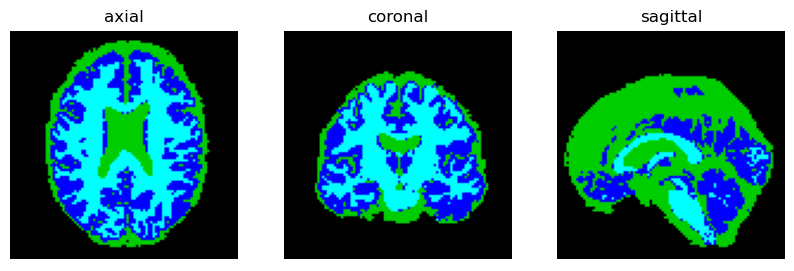

In [37]:
#display a sample from train segmentations
sample_image = dataset_train.get_sample(45)
display_axes(sitk.LabelToRGB(sample_image['seg']))

In [42]:
#Segmentation Model
class SegmentationModel(nn.Module):
    def __init__(self, num_classes):
        super(SegmentationModel, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(64, 32, kernel_size=3, padding=1) 
        self.conv4 = nn.Conv3d(32, num_classes, kernel_size=3, padding=1)


    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1))
        x3 = F.relu(self.conv3(x2))
        x4 = self.conv4(x3)
        
        return x4


MODEL TRAINING IN PROGRESS...
Epoch: 1 	Loss: 0.143355


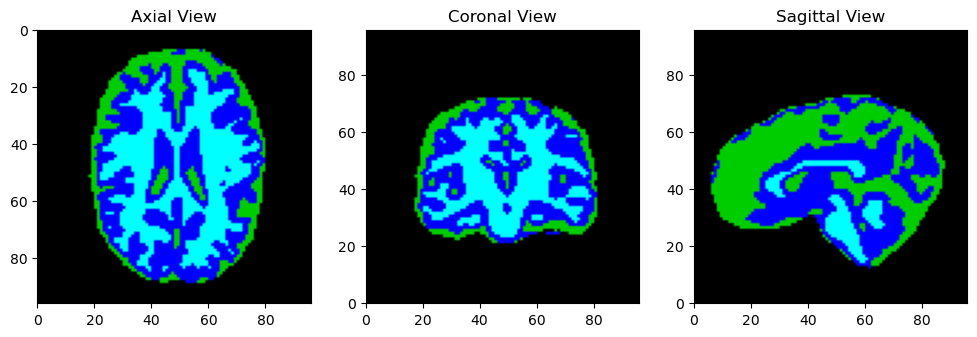

Epoch: 2 	Loss: 0.155809


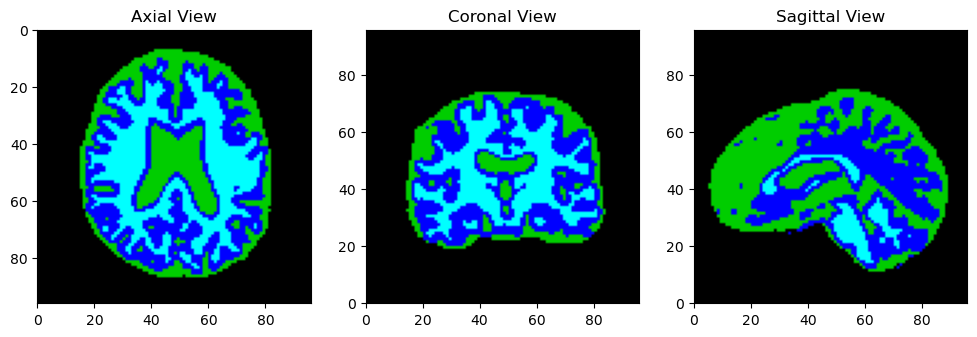

Epoch: 3 	Loss: 0.124431


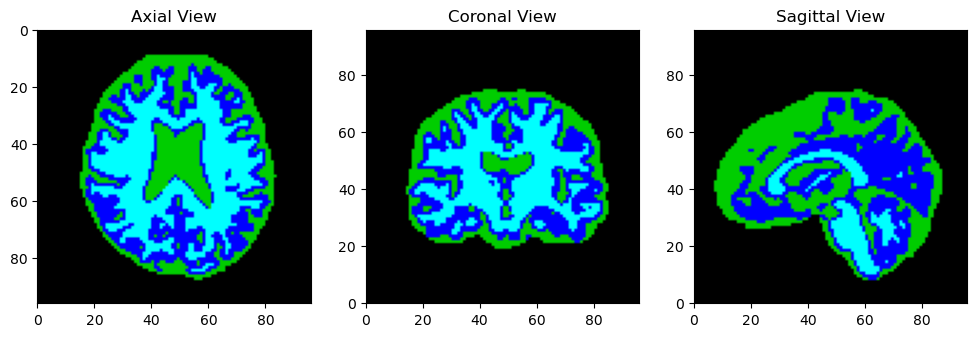

Epoch: 4 	Loss: 0.127216


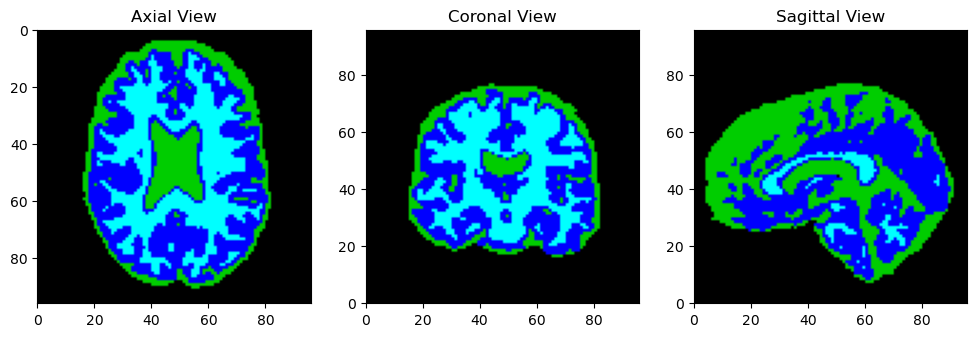

Epoch: 5 	Loss: 0.341114


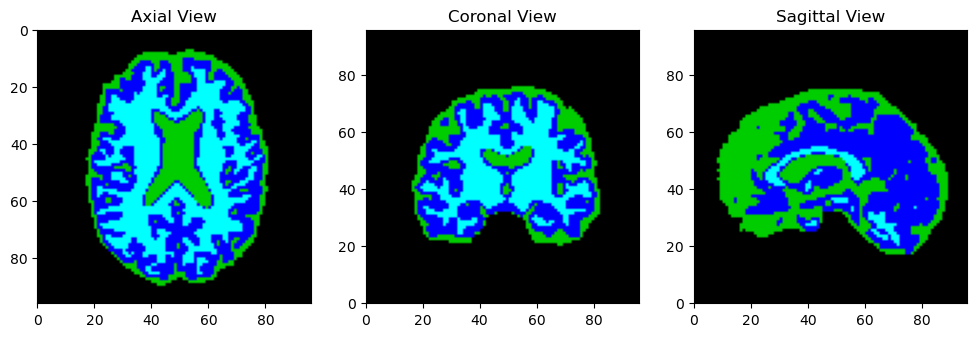

Epoch: 6 	Loss: 0.095708


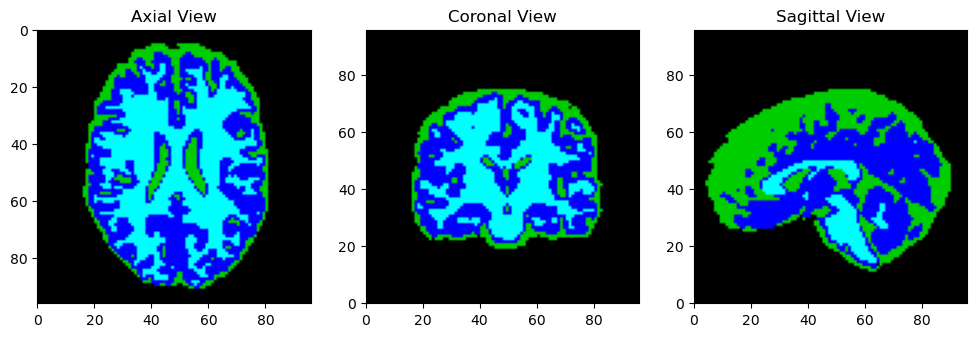

Epoch: 7 	Loss: 0.122106


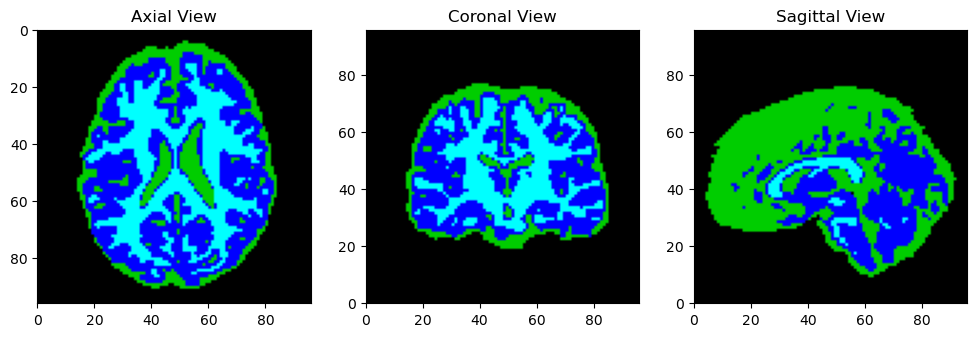

Epoch: 8 	Loss: 0.114686


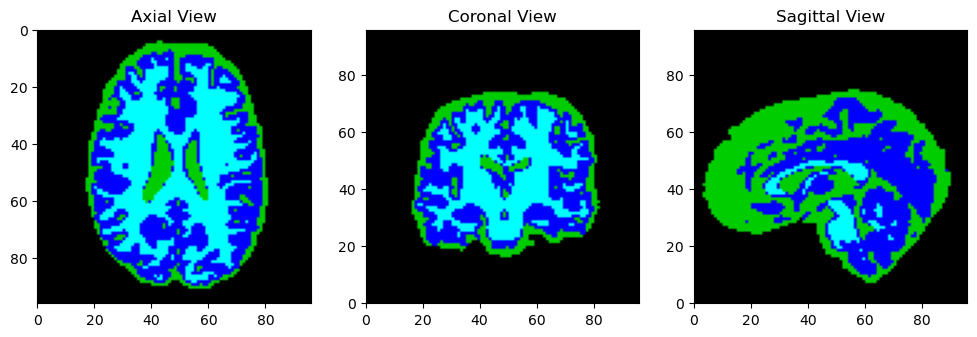

Epoch: 9 	Loss: 0.091281


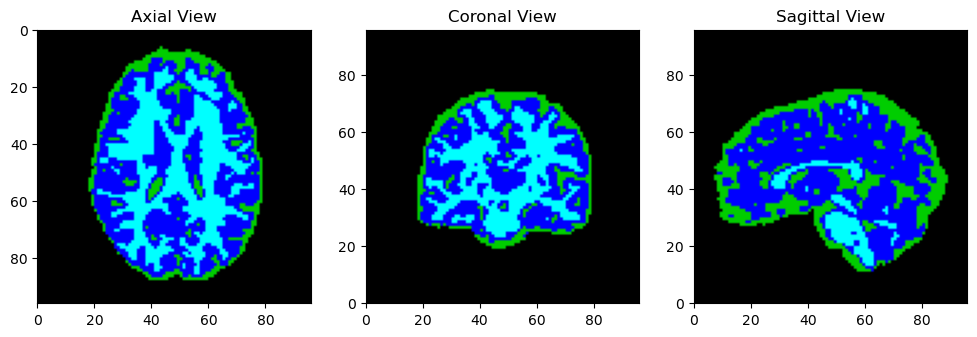

Epoch: 10 	Loss: 0.113173


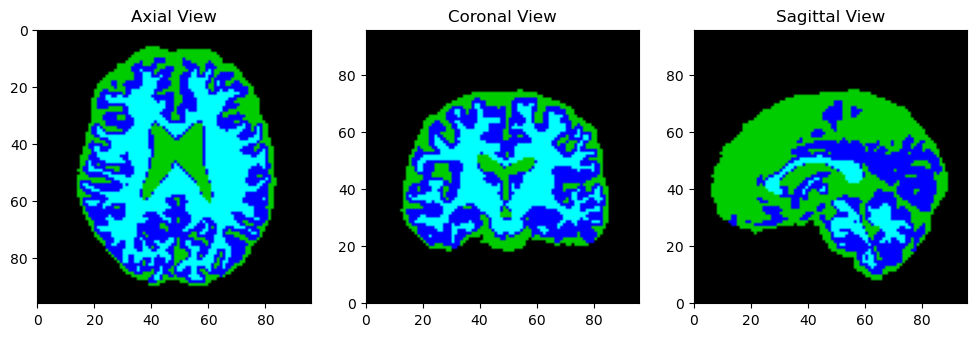

Epoch: 11 	Loss: 0.137927


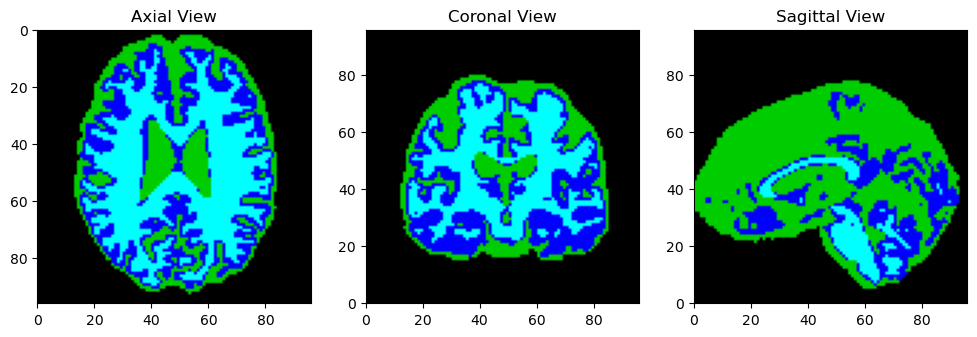

Epoch: 12 	Loss: 0.107733


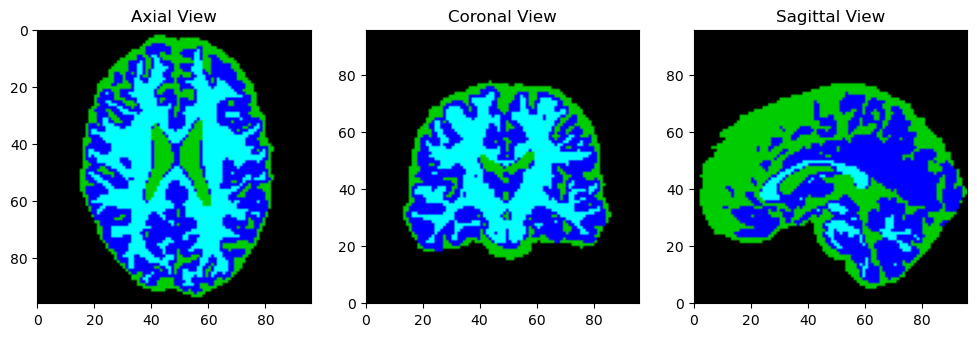

Epoch: 13 	Loss: 0.147434


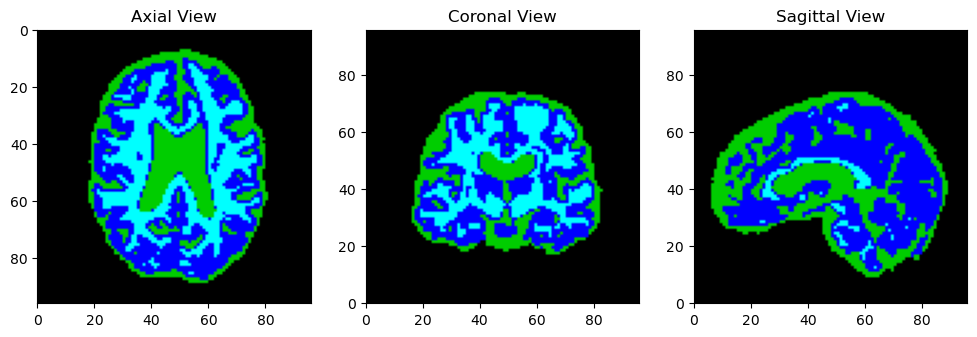

Epoch: 14 	Loss: 0.102757


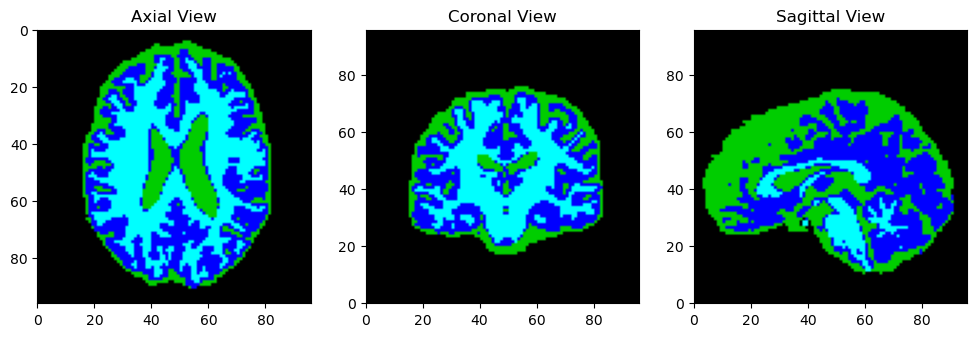

Epoch: 15 	Loss: 0.089937


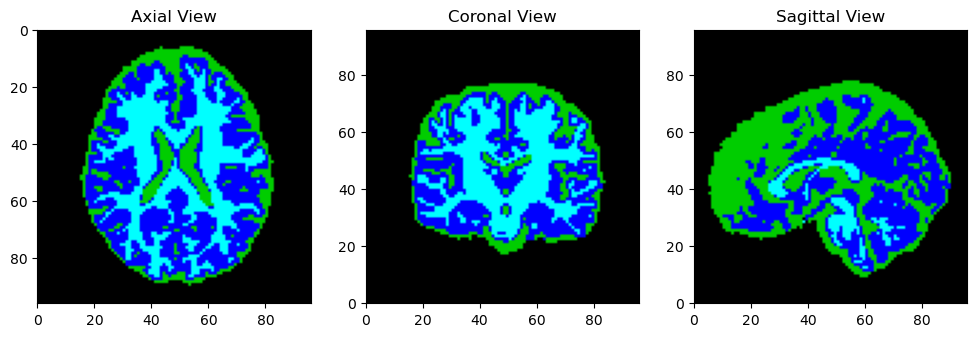

Epoch: 16 	Loss: 0.121051


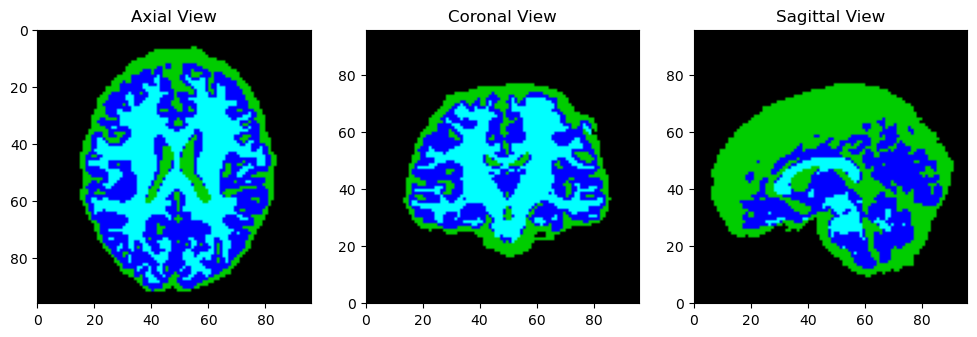

Epoch: 17 	Loss: 0.213507


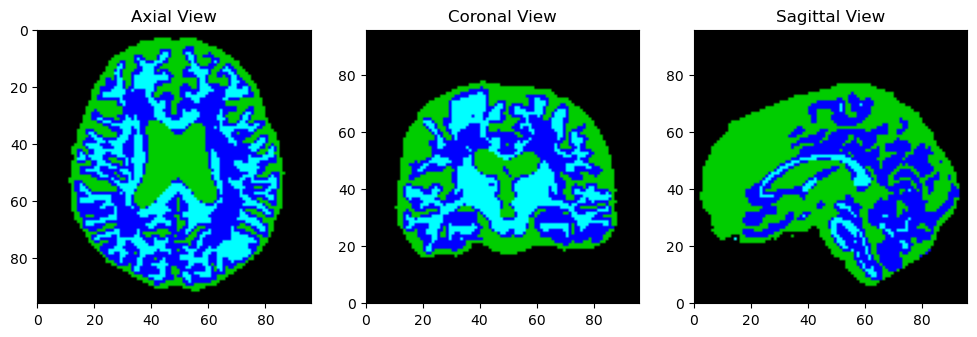

Epoch: 18 	Loss: 0.099853


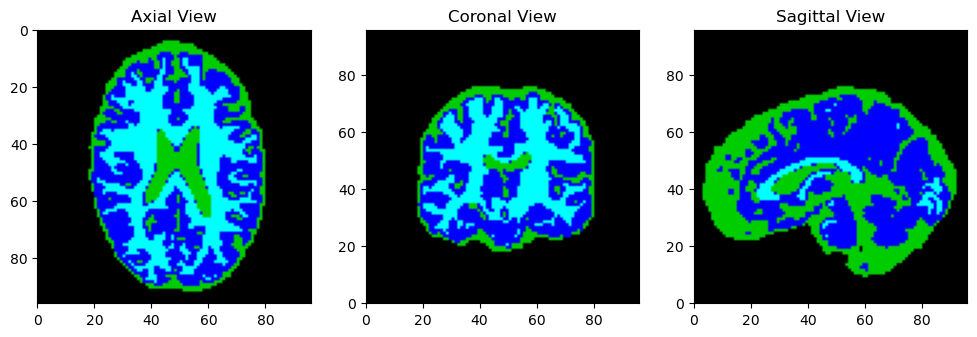

Epoch: 19 	Loss: 0.083441


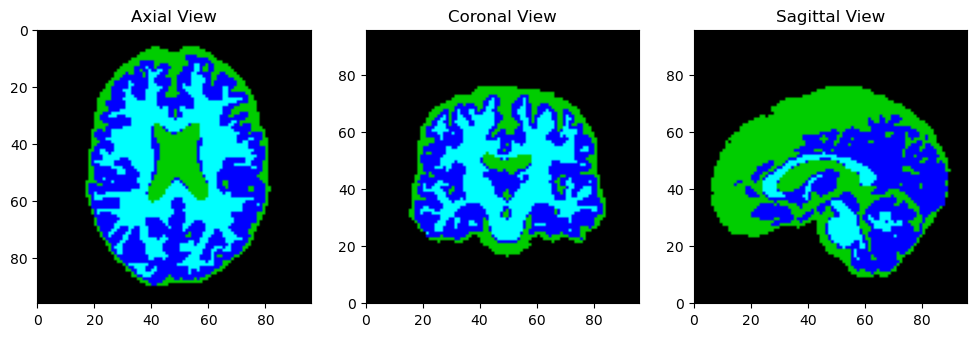

Epoch: 20 	Loss: 0.123492


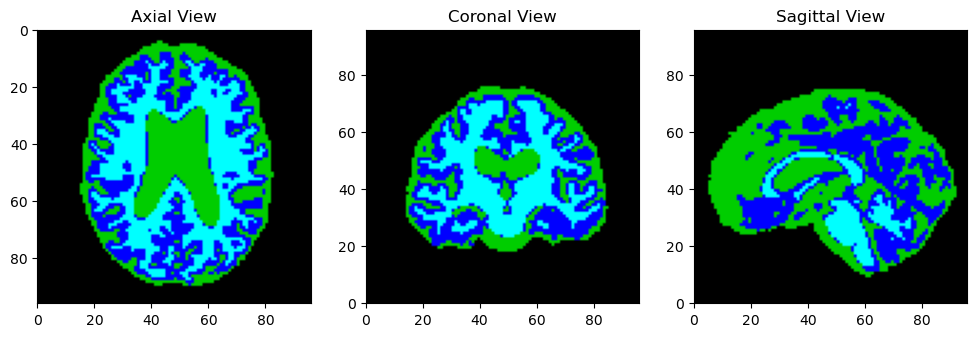

Epoch: 21 	Loss: 0.078715


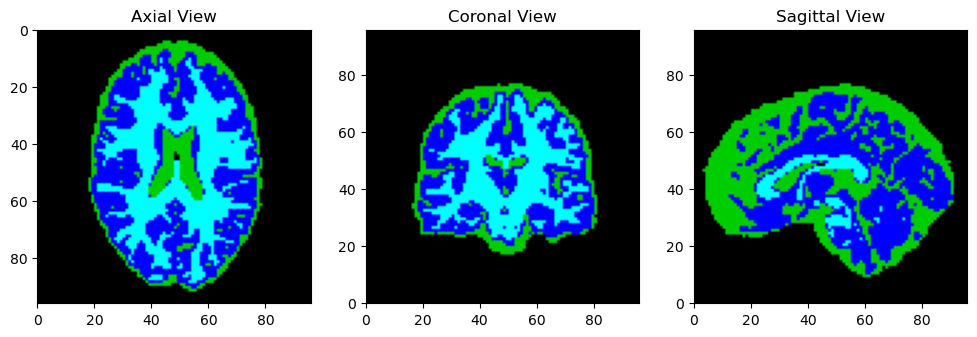

Epoch: 22 	Loss: 0.089923


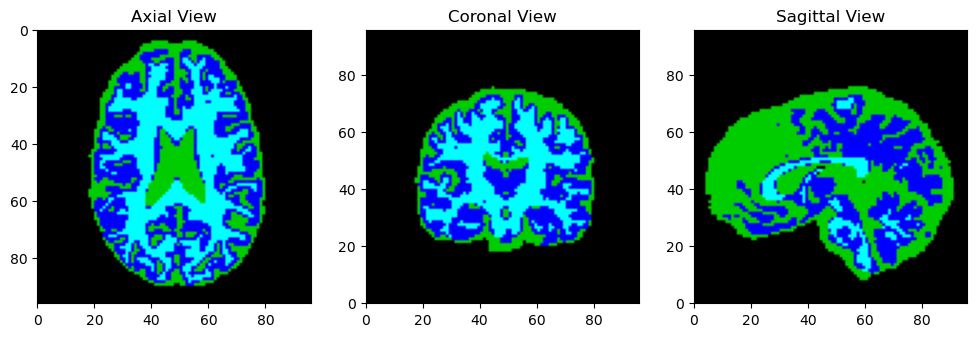

Epoch: 23 	Loss: 0.101848


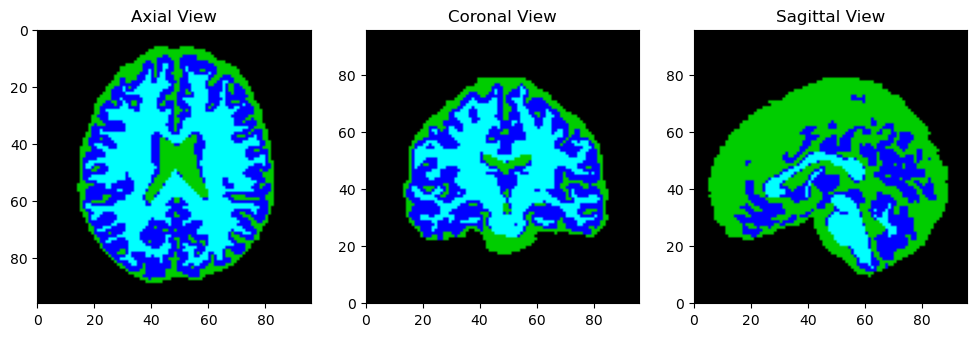

Epoch: 24 	Loss: 0.088836


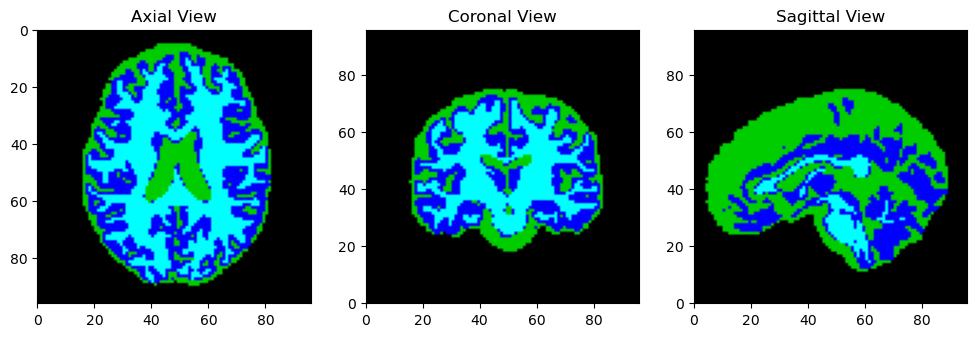

Epoch: 25 	Loss: 0.090328


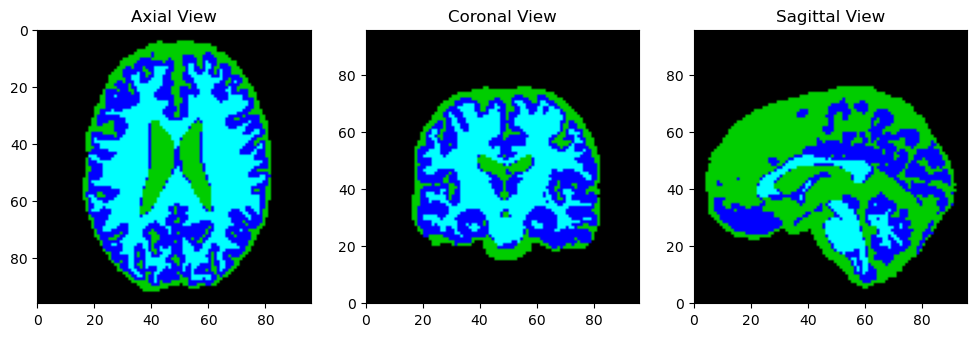


 Model training TRAINING completed.


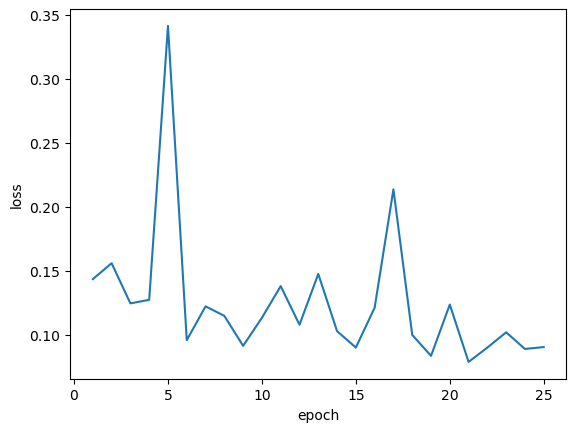

In [66]:
#TRAINING
model=SegmentationModel(num_classes=4).to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []


  
print('MODEL TRAINING IN PROGRESS...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        loss = F.cross_entropy(prd, seg.squeeze(1))
        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())
    

    print('Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    prd = torch.argmax(prd, dim=1)
    prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
    display_axes(sitk.LabelToRGB(prediction))
    

print('\n Model training TRAINING completed.')

plt.plot(range(1, num_epochs + 1), loss_train_log)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [67]:
# dataloader to load test set
dataset_test = ImageSegmentationDataset(image_test, segment_test, mask_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 131/131 [00:36<00:00,  3.61it/s]


In [72]:
#dice score calculator
def get_dice_score(pred, target):
    scores = []
    for i in range(4):
        preds = (pred == i).astype(bool)
        targets = (target == i).astype(bool)
        true_positive = np.sum( preds &  targets)
        false_positive = np.sum( preds & ~targets)
        true_negative = np.sum(~preds & ~targets)
        false_negative = np.sum(~preds &  targets)
        
        scores.append(2 * true_positive / (2 * true_positive + false_positive + false_negative))
        
    return scores

In [73]:
out_dir = './output'
pred_dir = os.path.join(out_dir, 'pred_segments')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

dice_scores = []
loss_test = 0
sum_pts = 0
idx_test = 0
with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
                  
        prd = torch.argmax(prd, dim=1)

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        
        dice = get_dice_score(prd.cpu().squeeze().numpy().astype(np.uint8), seg.cpu().squeeze().numpy().astype(np.uint8))
        dice_scores.append(dice)
        
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        
        idx_test += 1
        


print('Prediction Completed')

Prediction Completed


In [74]:
dice_averages = np.mean(dice_scores, axis=0)
print(dice_averages)

[0.9901026  0.78605082 0.8786184  0.9125117 ]


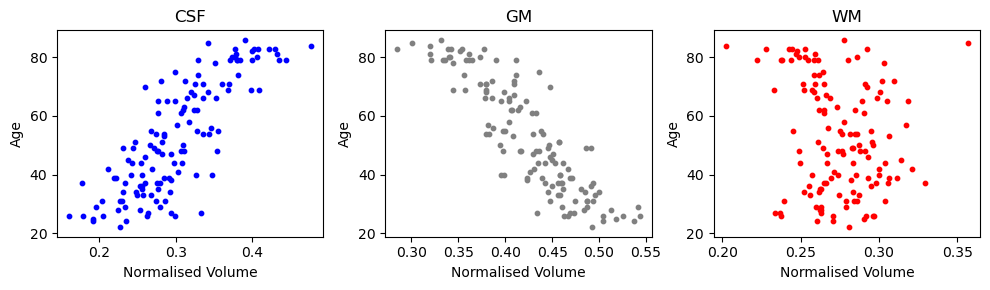

In [79]:
seg_dir = './output/pred_segments/'
fig, axs = plt.subplots(1, 3, figsize=(10, 3))


vols = np.zeros((3,len(segment_test)))

for idx, _ in enumerate(range(len(segment_test))):
    
    seg_filename = segment_test[idx]
    

    seg = sitk.ReadImage(seg_filename)
    seg_array = sitk.GetArrayFromImage(seg)
    vols[0, idx] = np.count_nonzero(seg_array == 1)
    vols[1, idx] = np.count_nonzero(seg_array == 2)
    vols[2, idx] = np.count_nonzero(seg_array == 3)

# #Normalize based on proportion
vols_normalised = np.zeros((3,len(segment_test)))
for i in range(len(segment_test)):
    i_vols = [vols[0,i], vols[1,i], vols[2,i]]
    range_vol = sum(i_vols)
    vols_normalised[0, i] = vols[0,i] / range_vol
    vols_normalised[1, i] = vols[1,i] / range_vol
    vols_normalised[2, i] = vols[2,i] / range_vol  # Adjust figsize as needed

# Scatter plot for CSF
axs[0].scatter(vols_normalised[0, :], meta_df_test['age'], c='blue', s=10)
axs[0].set_title('CSF')
axs[0].set_xlabel('Normalised Volume')
axs[0].set_ylabel('Age')

# Scatter plot for GM
axs[1].scatter(vols_normalised[1, :], meta_df_test['age'], c='gray', s=10)
axs[1].set_title('GM')
axs[1].set_xlabel('Normalised Volume')
axs[1].set_ylabel('Age')

# Scatter plot for WM
axs[2].scatter(vols_normalised[2, :], meta_df_test['age'], c='red', s=10)
axs[2].set_title('WM')
axs[2].set_xlabel('Normalised Volume')
axs[2].set_ylabel('Age')

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()